# Experiment for downstream localization models at ETB

In [1]:
# Dataset: MDCC Data Set 
# Candidates for downstream models:
# KNN, Random Forest (RF), Decision Tree (DT) and Gasussian Processes (GSs)

In [2]:
import numpy as np
import json
import math
import glob
import os
import google.protobuf
from collections import Counter
import matplotlib.pyplot as plt
import sklearn
import pandas as pd 
from pandas import DataFrame, concat
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import linalg as LA
import statistics
import matplotlib.pyplot as plt
import importlib

In [3]:
buildingname =  'ETB'
floorlevel = 1

In [4]:
import Data_pb2
from Utils import distance,offset_coord,gps_fromxy,gps2local,get_file_list,load_data_packs,location_interpolate
from Utils import parse_path_packages,parse_point_packages

#load building information
with open('building_dict.json') as fin:
    building_dict = json.load(fin)

#find a reference gps location for a local coordinate system
gpspo = np.array(building_dict[buildingname]['gpspo'])
gps_origin=tuple(np.min(gpspo,axis=0))

In [5]:
#Load the data packages
data_folder = os.path.join('FpData',buildingname,str(floorlevel))
print('The data folder is in:',data_folder)
#1. Load path-based data and verify the building and floor level
path_packages = []
path_data_files = get_file_list(data_folder, 1)
if len(path_data_files)>0:
    path_packages = load_data_packs(path_data_files)
    for i,path_package in enumerate(path_packages):
        assert path_package.buildingName==buildingname, "building mismatch, delete file and retry: "+path_data_files[i]
        assert int(path_package.floorLevel)==int(floorlevel), "floor mismatch, delete fine and retry:"+path_data_files[i]
print('The number of path-based collection',len(path_packages))
print(path_data_files)
#2. Load the point-based data and verify the building and floor level
point_packages = []
point_data_files = get_file_list(data_folder, 2)
if len(point_data_files)>0:
    point_packages = load_data_packs(point_data_files)
    for i,point_package in enumerate(point_packages):
        assert point_package.buildingName==buildingname, "building  mismatch,delete file and retry:"+point_data_files[i]
        assert int(point_package.floorLevel)==int(floorlevel), "floor  mismatch,delete file and retry:"+point_data_files[i]
print('The number of point-based collection',len(point_packages))

#3. Load the test data
test_packages = []
test_data_files = get_file_list(os.path.join('FpData',buildingname,str(floorlevel),'test'), 2)
if len(test_data_files)>0:
    test_packages = load_data_packs(test_data_files)
    for test_package in point_packages:
        assert test_package.buildingName==buildingname, "building name mismatch"
        assert test_package.floorLevel==floorlevel, "floor level mismatch"
print('The number of test points',len(test_packages))


The data folder is in: FpData/ETB/1
The number of path-based collection 7
['/Users/lawrence/Downloads/IPS/FpData/ETB/1/liu433_1_20190901125344.pbf', '/Users/lawrence/Downloads/IPS/FpData/ETB/1/liu433_1_20190901125457.pbf', '/Users/lawrence/Downloads/IPS/FpData/ETB/1/shil9_1_20190930165458.pbf', '/Users/lawrence/Downloads/IPS/FpData/ETB/1/campbi1_1_20191017163913.pbf', '/Users/lawrence/Downloads/IPS/FpData/ETB/1/elmokatk_1_20191128130055.pbf', '/Users/lawrence/Downloads/IPS/FpData/ETB/1/gelerius_1_20191004180216.pbf', '/Users/lawrence/Downloads/IPS/FpData/ETB/1/gelerius_1_20191004151918.pbf']
The number of point-based collection 0
The number of test points 20


In [8]:
# APs seen by less than this value will be ignored.
Freq_threshold = 35

#Select the Effective Access Points since some Access Points may just temporary
AP_bssids = []
for pack in point_packages:
    for e in pack.rssItems:
        AP_bssids.append(e.bssid)
for pack in path_packages:
    for e in pack.rssItems:
        AP_bssids.append(e.bssid)
AP_bssids_count = dict(Counter(AP_bssids))
#remove APs only seen sporadically. 
AP_bssids_common = {k:v for k,v in AP_bssids_count.items() if v > Freq_threshold}
#create a dict for the AP_bssid index for convenience to organize the fingerprint vector
AP_bssids_index_dict = {k:v for k,v in zip(AP_bssids_common.keys(),range(len(AP_bssids_common)))}

if len(AP_bssids_index_dict)<3:
    print('Error, AP_bssids_index_dict is too small, please collect more data or set Freq_threshold to a smaller value')

In [9]:
path_FPs, path_labels = parse_path_packages(path_packages,AP_bssids_index_dict)
point_FPs, point_labels = parse_point_packages(point_packages,AP_bssids_index_dict)
test_FPs, test_labels = parse_point_packages(test_packages,AP_bssids_index_dict)
print (len(path_FPs))
print (len(path_FPs[0]))

path length is 55.147951 meter
path length is 53.853781 meter
path length is 64.081829 meter
path length is 50.583079 meter
path length is 15.883939 meter
path length is 27.246838 meter
path length is 54.393225 meter
79
8


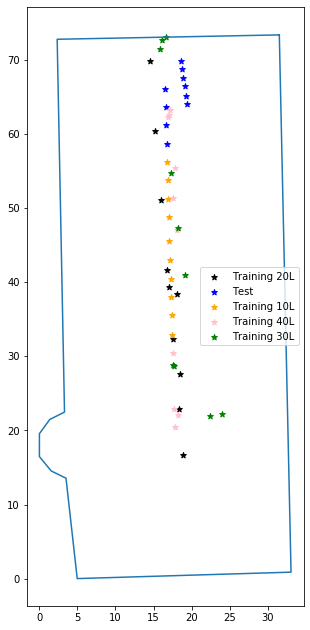

In [17]:
#plot your target building structure and the locations you collected data
local_poly = [offset_coord(gps_origin[1],gps_origin[0],lat,lon) for lon,lat in gpspo]
x_scale,y_scale=np.max(local_poly,axis=0) - np.min(local_poly,axis=0)
fig, ax = plt.subplots(1, 1, figsize=(x_scale*0.15,y_scale*0.15)) 
local_poly = np.array(local_poly)
ax.plot(*zip(*local_poly))

path_locs = gps2local(gps_origin,path_labels)
point_locs = gps2local(gps_origin,point_labels)
test_locs = gps2local(gps_origin,test_labels)

train_data = pd.DataFrame(np.append(np.array(path_FPs),np.array(test_FPs),axis=0),index=None, columns=None)
train_locs = pd.DataFrame(np.append(np.array(path_locs),np.array(test_locs),axis=0),index=None, columns=None)
# drop null
train_data.drop(train_locs[train_locs[0].isna()].index,inplace=True)
train_locs.dropna(inplace=True)
data_set = pd.concat([train_data,train_locs],axis=1)

training_data = np.array(data_set)[50:90]




ax.scatter(np.array(data_set)[:10][:,-2],np.array(data_set)[:10][:,-1],c='black',marker='*',label="Training 20L")
ax.scatter(np.array(data_set)[50:60][:,-2],np.array(data_set)[50:60][:,-1],c='blue',marker='*',label="Test")
ax.scatter(np.array(data_set)[60:70][:,-2],np.array(data_set)[60:70][:,-1],c='orange',marker='*',label="Training 10L")
ax.scatter(np.array(data_set)[70:80][:,-2],np.array(data_set)[70:80][:,-1],c='pink',marker='*',label="Training 40L")
ax.scatter(np.array(data_set)[80:90][:,-2],np.array(data_set)[80:90][:,-1],c='green',marker='*',label="Training 30L")
ax.legend()
plt.show()

In [39]:
test_data = np.array(data_set)[50:60]
test_data.shape

(10, 10)

In [28]:
training_data = pd.concat([data_set[60:70],data_set[:10],data_set[80:90],data_set[70:80]],axis=0).to_numpy()
training_data.shape

(40, 10)

In [29]:
# shuffling the training data 
# np.random.shuffle(training_data)

# Downstream model performacne evaluation

In [30]:
training_data_10L =  training_data[:10]
training_data_10U =  training_data[10:20]
training_data_20L =  training_data[:20]
training_data_20U =  training_data[10:30]
training_data_30L =  training_data[:30]
training_data_30U =  training_data[10:40]
training_data_40L =  training_data[:40]

In [31]:
# Label Propagation 

In [32]:
import downstream_models.localization_models as models
importlib.reload(models)
import DG_SSL.dg_ssl as dg_ssl
importlib.reload(dg_ssl)

<module 'DG_SSL.dg_ssl' from '/Users/lawrence/Downloads/IPS/DG_SSL/dg_ssl.py'>

In [44]:
training_data

array([[-93.        , -93.        , -54.        , -93.        ,
        -93.        , -70.        , -66.        , -93.        ,
         16.80412771,  56.27837323],
       [-93.        , -93.        , -55.        , -93.        ,
        -93.        , -66.        , -68.        , -93.        ,
         16.87136908,  53.79077774],
       [-93.        , -93.        , -93.        , -93.        ,
        -93.        , -62.        , -74.        , -93.        ,
         16.93904537,  51.2870926 ],
       [-93.        , -93.        , -93.        , -93.        ,
        -71.        , -65.        , -78.        , -93.        ,
         17.00639231,  48.79559152],
       [-93.        , -68.        , -93.        , -69.        ,
        -64.        , -70.        , -93.        , -93.        ,
         17.0940805 ,  45.55156603],
       [-93.        , -93.        , -93.        , -93.        ,
        -64.        , -74.        , -93.        , -93.        ,
         17.1633317 ,  42.98961662],
       [-6

In [34]:
propagation_results_10L_10U = dg_ssl.dg_ssl_init(training_data_10L,training_data_10U)[0]
print (dg_ssl.prop_error(propagation_results_10L_10U[10:,-2:],training_data_10U[:,-2:]))
print (dg_ssl.prop_error(propagation_results_10L_10U[:10,-2:],training_data_10L[:,-2:]))

9.530082410490682
0.8153136981927356


In [35]:
propagation_results_10L_20U = dg_ssl.dg_ssl_init(training_data_10L,training_data_20U)[0]
print (dg_ssl.prop_error(propagation_results_10L_20U[10:,-2:],training_data_20U[:,-2:]))
print (dg_ssl.prop_error(propagation_results_10L_20U[:10,-2:],training_data_10L[:,-2:]))

14.863486433270964
2.8032961181171983


In [36]:
propagation_results_10L_30U = dg_ssl.dg_ssl_init(training_data_10L,training_data_30U)[0]
print (dg_ssl.prop_error(propagation_results_10L_30U[10:,-2:],training_data_30U[:,-2:]))
print (dg_ssl.prop_error(propagation_results_10L_30U[:10,-2:],training_data_10L[:,-2:]))

14.652180325434774
4.4428851194802785


In [37]:
# model performance of KNN, DT and RF for different training data 

In [40]:
downstream_models_results_10L = models.evaluation_reg(training_data_10L,test_data,[10,0])
downstream_models_results_20L = models.evaluation_reg(training_data_20L,test_data,[20,0])
downstream_models_results_30L = models.evaluation_reg(training_data_30L,test_data,[30,0])
downstream_models_results_40L = models.evaluation_reg(training_data_40L,test_data,[40,0])
downstream_models_results_10L_10U = models.evaluation_reg(propagation_results_10L_10U,test_data,[10,10])
downstream_models_results_10L_20U = models.evaluation_reg(propagation_results_10L_20U,test_data,[10,20])
downstream_models_results_10L_30U = models.evaluation_reg(propagation_results_10L_30U,test_data,[10,30])

Knn error(m) - 12.37288088175973
Random Forest error(m)- 13.076647962751272
Decision Tree error(m)- 12.607936759472995
 
Knn error(m) - 12.37288088175973
Random Forest error(m)- 14.11799889191688
Decision Tree error(m)- 12.607936759472995
 
Knn error(m) - 11.111153135414913
Random Forest error(m)- 10.70329594220896
Decision Tree error(m)- 12.006797536393336
 
Knn error(m) - 6.672926735090927
Random Forest error(m)- 6.052530699216385
Decision Tree error(m)- 4.232675701911166
 
Knn error(m) - 11.939172936924319
Random Forest error(m)- 14.92992299238846
Decision Tree error(m)- 11.939172936924319
 
Knn error(m) - 9.834440388183737
Random Forest error(m)- 14.944932559027858
Decision Tree error(m)- 25.197213200049326
 
Knn error(m) - 16.91226866760079
Random Forest error(m)- 16.31449174498728
Decision Tree error(m)- 16.91226866760079
 


In [ ]:
# Model performance of GPs for different training data 

In [56]:
# Train GPs 
import importlib
import gps_deployment.gps_starting as gps
import gps_deployment.main_controller as gps1
import gps_deployment.gaussian as gps2

In [54]:
importlib.reload(gps)
importlib.reload(gps1)
importlib.reload(gps2)

<module 'gps_deployment.gaussian' from '/Users/lawrence/Downloads/IPS/gps_deployment/gaussian.py'>

In [45]:
gps_results_10L = gps.gps_start(8,training_data_10L)
gps_results_20L = gps.gps_start(8,training_data_20L)
gps_results_30L = gps.gps_start(8,training_data_30L)
gps_results_40L = gps.gps_start(8,training_data_40L)

In [55]:
rlt_10L = gps.gps_evaluation(gps_results_10L,8,test_data,[10,0])
rlt_20L = gps.gps_evaluation(gps_results_20L,8,test_data,[20,0])
rlt_30L = gps.gps_evaluation(gps_results_30L,8,test_data,[30,0])
rlt_40L = gps.gps_evaluation(gps_results_40L,8,test_data,[40,0])

GPs error: 22.325797153248445
GPs error: 28.43748393333351
GPs error: 18.995456910472214
GPs error: 14.400333873150096


In [49]:
gps_results_10L_10L = gps.gps_start(8,propagation_results_10L_10U)
gps_results_10L_20L = gps.gps_start(8,propagation_results_10L_20U)
gps_results_10L_30L = gps.gps_start(8,propagation_results_10L_30U)

In [57]:
rlt_10L_10U = gps.gps_evaluation(gps_results_10L_10L,8,test_data,[10,10])
rlt_10L_20U = gps.gps_evaluation(gps_results_10L_20L,8,test_data,[10,20])
rlt_10L_30U = gps.gps_evaluation(gps_results_10L_30L,8,test_data,[10,30])

GPs error: 21.333596189596634
GPs error: 19.098471439772283
GPs error: 27.853418990072228
